# Soft Iron Calibration
## ---------------------------
### Version 1 - Date 14/06/22
### Author: Víctor Vegas Luque - victorvegas24@gmail.com

In [2]:
import math 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from plotly.subplots import make_subplots
import numpy as np
#SciPy es una bibliteca de algoritmos matematicos. En este caso la funcion eigh nos permite obtener los autovalores y autovectores de una matriz)
from scipy.linalg import eigh

In [3]:



def FitEllipsoid(X,flag):

    #X: matriz nx3 de valores de los que se quieren hacer fit
    x=X[:,0]
    y=X[:,1]
    z=X[:,2]

    #Ligaduras:
    #Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz + J = 0
    #A + B + C = 3
    flag=''
    #Se necesitan 9 parametros al menos. Los flags nos quitaran algunos extras
    if flag=='':
        D = [np.multiply(x,x)+np.multiply(y,y)-2*np.multiply(z,z),np.multiply(x,x)+np.multiply(z,z)-2*np.multiply(y,y),2*np.multiply(x,y),2*np.multiply(x,z),2*np.multiply(y,z),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='xy':
        D = [np.multiply(x,x)+np.multiply(y,y)-2*np.multiply(z,z),2*np.multiply(x,y),2*np.multiply(x,z),2*np.multiply(y,z),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='xz':
        D = [np.multiply(x,x)+np.multiply(z,z)-2*np.multiply(y,y),2*np.multiply(x,y),2*np.multiply(x,z),2*np.multiply(y,z),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='0':
        D = [np.multiply(x,x)+np.multiply(y,y)-2*np.multiply(z,z),np.multiply(x,x)+np.multiply(z,z)-2*np.multiply(y,y),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='0xy':
        D = [np.multiply(x,x)+np.multiply(y,y)-2*np.multiply(z,z),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='0xz':
        D = [np.multiply(x,x)+np.multiply(z,z)-2*np.multiply(y,y),np.multiply(x,2),np.multiply(y,2),np.multiply(z,2),1+0*x]
    elif flag=='xyz':
        D = [2*x,2*y,2*z,1+0*x]
    else:
        Print("Numero de parametros desconocido")
        return
    d2=np.multiply(x,x)+np.multiply(y,y)+np.multiply(z,z)
    d2=np.asmatrix(d2)
    #https://stackoverflow.com/questions/7160162/left-matrix-division-and-numpy-solve
    u=np.linalg.lstsq(np.matmul(D,np.transpose(D)),np.transpose(np.matmul(d2,np.transpose(D))),rcond=None)
    u=u[0]

    #Encontramos cada uno de los terminos que definen nuestro elipsoide
    v=[0]*9
    if flag=='':
        v[0]=u[0]+u[1]-1
        v[1]=u[0]-2*u[1]-1
        v[2]=u[1]-2*u[0]-1
        v[3:10]=u[2:9]
    elif flag=='xy':
        v[0]=u[0]-1
        v[1]=u[0]-1
        v[2]=-2*u[0]-1
        v[3:10]=u[1:8]
    elif flag=='xz':
        v[0]=u[0]-1
        v[1]=-2*u[0]-1
        v[2]=u[0]-1
        v[3:10]=u[1:8]
    elif flag=='0':
        v[0]=u[0]+u[1]-1
        v[1]=u[0]-2*u[1]-1
        v[2]=u[1]-2*u[0]-1
        v[3:6]=0.0
        v[7:10]=u[2:6]
    elif flag=='0xy':
        v[0]=u[0]-1
        v[1]=u[0]-1
        v[2]=-2*u[0]-1
        v[3:6]=0.0
        v[7:10]=u[1:5]
    elif flag=='0xz':
        v[0]=u[0]-1
        v[1]=-2*u[0]-1
        v[2]=u[0]-1
        v[3:6]=0.0
        v[7:10]=u[1:5]
    elif flag=='xyz':
        v[0:3]=-1.0
        v[3:6]=0.0
        v[7:10]=u[0:4]
    
    #Construimos la matriz que define el elipsoide
    v=np.asarray(v)
    A=[[0.0,0.0,0.0,0.0]]*4
    A=np.asarray(A)
    A[0][0]=v[0]
    A[1][1]=v[1]
    A[2][2]=v[2]
    A[3][3]=v[9]
    A[0][1]=A[1][0]=v[3]
    A[0][2]=A[2][0]=v[4] 
    A[0][3]=A[3][0]=v[6]
    A[1][2]=A[2][1]=v[5]
    A[1][3]=A[3][1]=v[7]
    A[2][3]=A[3][2]=v[8]
    
       
    v=np.transpose(np.asmatrix(v))
    
    
    #Encontramos el centro del elipsoide
    center=np.linalg.lstsq(A[0:3,0:3],v[6:9],rcond=None)
    center=np.asmatrix(center[0])
    center=-1*center
    
    #Definimso la matriz de rotacion
    T=np.identity(4)
    T[3][0]=center[0]
    T[3][1]=center[1]
    T[3][2]=center[2]
    
    R=np.matmul(T,np.matmul(A,np.transpose(T)))


    #Resolvemos la ecuacion de autovalores
    eigvals, eigvecs = eigh((R[0:3,0:3])/(R[3][3]), np.identity(3), eigvals_only=False,)
    radii=np.sqrt(1.0/(np.diag(np.absolute(eigvals))))
    sign=np.sign(eigvals)
    for i in range(3):
        radii[i][i]=radii[i][i]*sign[0]

    return center, radii, eigvecs, v

In [4]:
#
#
#CODIGO PARA LEER LOS DATOS EXPERIMENTALES
#
#
Data_File="mag.txt"

X=np.loadtxt(Data_File)


x=X[:,6]
y=X[:,7]
z=X[:,8]

x=np.asarray(x)
y=np.asarray(y)
z=np.asarray(z)



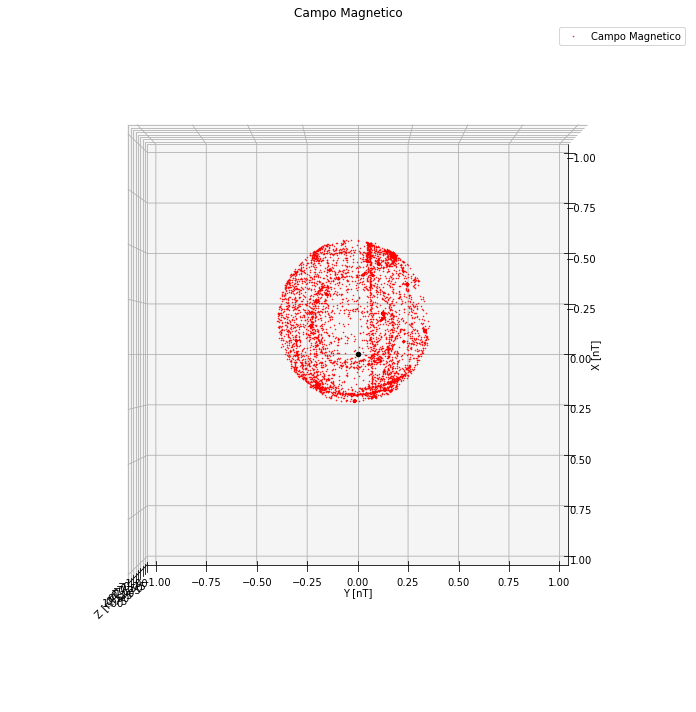

In [5]:
lim=0.5
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(10)

ax = plt.axes(projection ='3d')

ax.set_title("Campo Magnetico")

ax.plot3D(x,y,z, 'r.',markersize=1,label='Campo Magnetico')



ax.scatter(0,0,0,color='black')
ax.set_xlabel('X [nT]')
ax.set_ylabel('Y [nT]')
ax.set_zlabel('Z [nT]')
ax.view_init(elev=90., azim=0)
plt.legend(loc='upper right')
plt.grid()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.tight_layout()

plt.show()

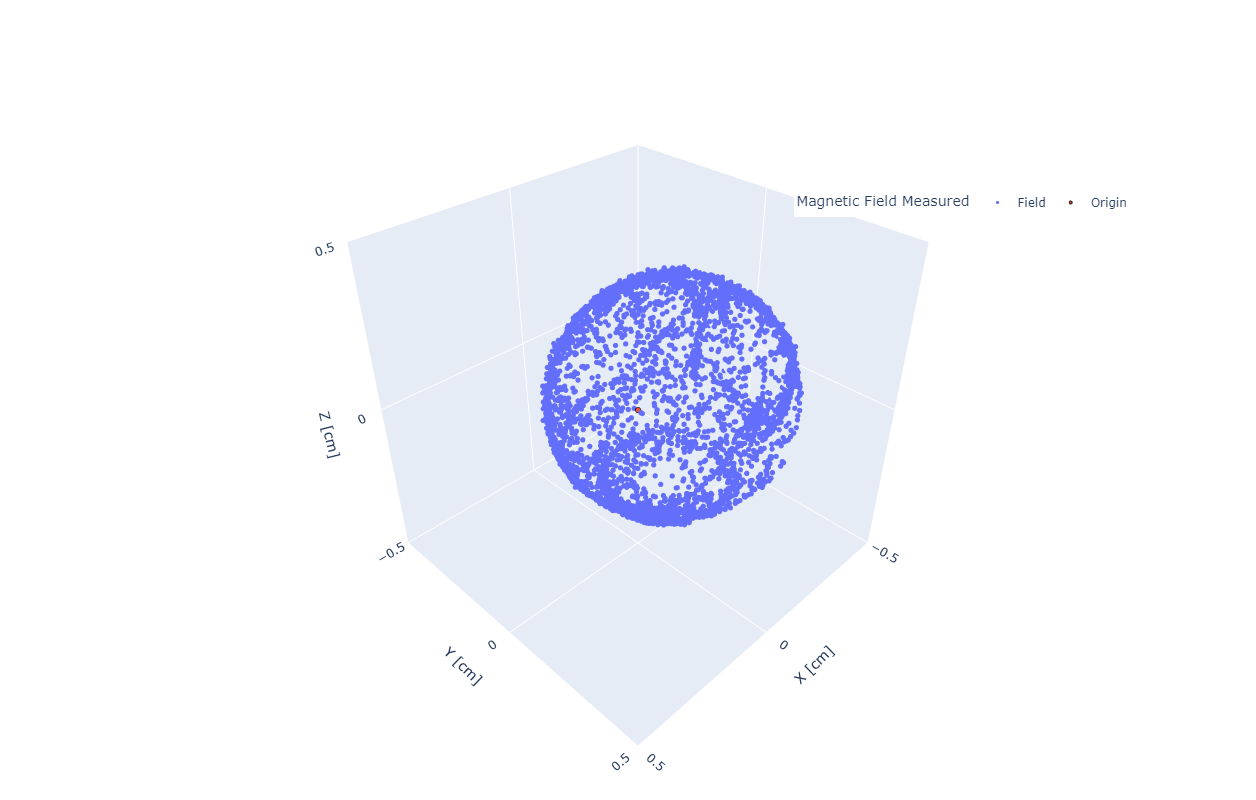

In [6]:


import plotly.graph_objects as go
import numpy as np

data2=[go.Scatter3d(x=x,y=y,z=z,
                   mode='markers',
                   name="Field",
                   opacity=1.0,
                   marker=dict(size=3,line=dict(width=0)), 
                  ),
      go.Scatter3d(x=[0],y=[0],z=[0],mode='markers',name='Origin',
                  marker=dict(size=3,line=dict(color="black",width=1)),)
                  
      ]

layout = go.Layout(
    #title='Posiciones de medida del campo para el Magnetometro 2 representado con PlotLy',
    autosize=True,
    showlegend=True,
    legend_title="Magnetic Field Measured",

#    font=dict( family="Courier New, monospace", size=8, color="RebeccaPurple"),
    scene = dict(   xaxis_title='X [cm]',xaxis = dict(nticks=5, range=[-lim,lim]),
                    yaxis_title='Y [cm]',yaxis = dict(nticks=5, range=[-lim,lim]),
                    zaxis_title='Z [cm]',zaxis = dict(nticks=5, range=[-lim,lim])
                ),  
                margin=dict(t=40, r=0, l=20, b=20)
)
#How camera controls work
#The camera position and direction is determined by three vectors: up, center, eye. 
# Their coordinates refer to the 3-d domain, i.e., (0, 0, 0) is always the center of the domain, no matter data values.
# The eye vector determines the position of the camera. The default is $(x=1.25, y=1.25, z=1.25)$.
# The up vector determines the up direction on the page. The default is $(x=0, y=0, z=1)$, that is, the z-axis points up.
# The projection of the center point lies at the center of the view. By default it is $(x=0, y=0, z=0)$.
# 
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=2)
)
#Posición de la Leyenda
legend=dict(
    orientation="h",
    yanchor="top",   y=0.8,
    xanchor="right", x=0.9
)

fig2 = go.Figure(data2,layout)
fig2.update_layout(scene_camera=camera, width=800, height=800,legend=legend)
#Ratio de aspecto para que todos loso ejes se vean con el mismo tamaño
fig2.update_layout(
        scene = dict(
            aspectmode='cube'
        ))
fig2.show()

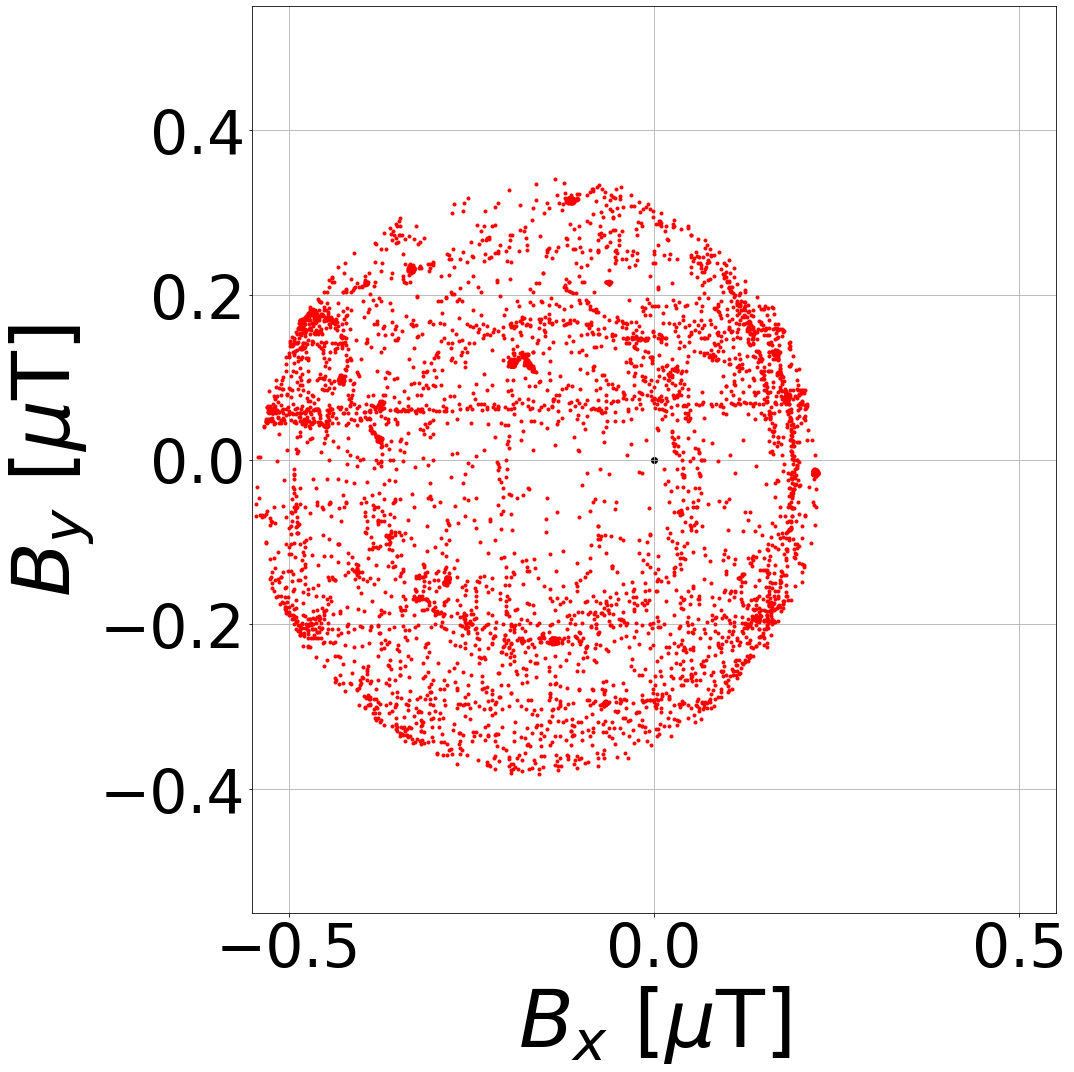

In [14]:
lim=0.55
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)




plt.plot(x,y,'r.',markersize=6)

plt.tick_params(axis='x', labelsize=60)
plt.tick_params(axis='y', labelsize=60)

plt.scatter(0,0,color='black')
plt.xlabel('$B_x$ [$\mu$T]',size=80)
plt.ylabel('$B_y$ [$\mu$T]',size=80)


plt.grid()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


plt.tight_layout()

plt.savefig('XYCalib.png', format='png')

plt.show()

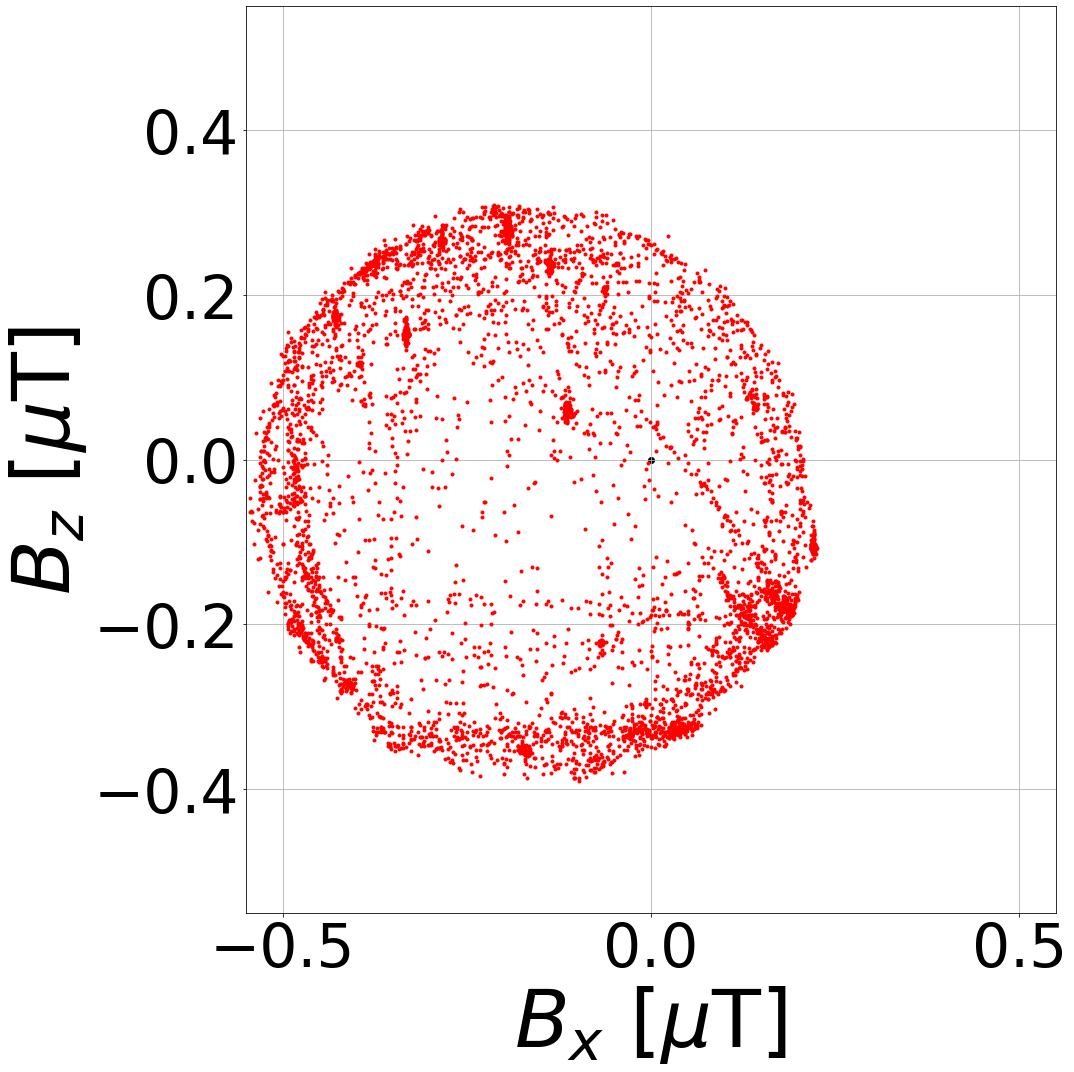

In [15]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)




plt.plot(x,z,'r.',markersize=6)

plt.tick_params(axis='x', labelsize=60)
plt.tick_params(axis='y', labelsize=60)

plt.scatter(0,0,color='black')
plt.xlabel('$B_x$ [$\mu$T]',size=80)
plt.ylabel('$B_z$ [$\mu$T]',size=80)


plt.grid()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


plt.tight_layout()

plt.savefig('XZCalib.png', format='png')

plt.show()

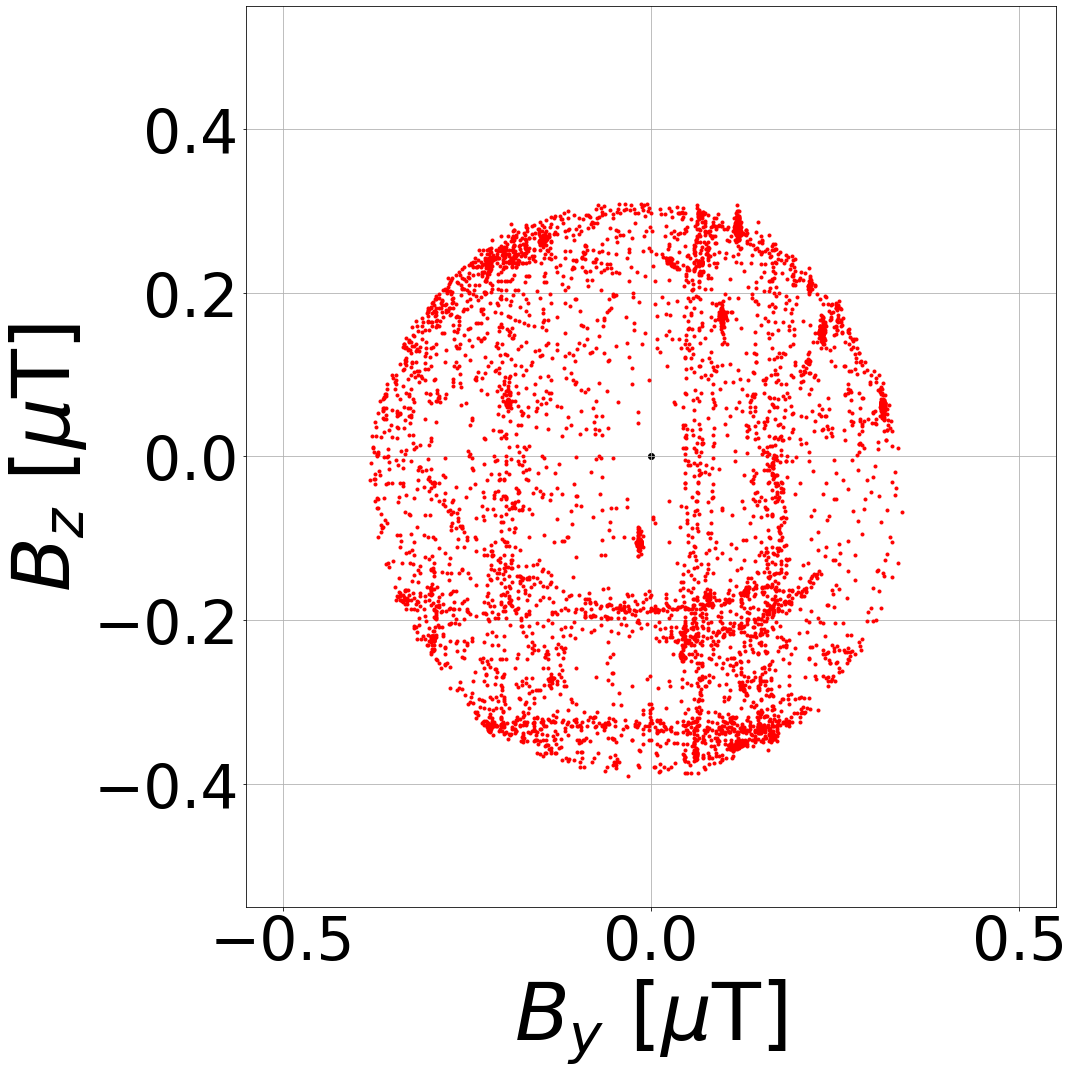

In [16]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)




plt.plot(y,z,'r.',markersize=6)

plt.tick_params(axis='x', labelsize=60)
plt.tick_params(axis='y', labelsize=60)

plt.scatter(0,0,color='black')
plt.xlabel('$B_y$ [$\mu$T]',size=80)
plt.ylabel('$B_z$ [$\mu$T]',size=80)


plt.grid()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


plt.tight_layout()

plt.savefig('YZCalib.png', format='png')

plt.show()

In [14]:
center,radii,eigvecs,v=FitEllipsoid(X[:,6:9],'')


#Centramos nuestros datos experimentales
S=[x-center[0].item(0),y-center[1].item(0),z-center[2].item(0)]


scale=1.0/radii
invmapa=eigvecs
mapa=np.transpose(invmapa)

print(radii)

#Matriz que, en este orden: rota (para que coincidan los ejes principales), reescala los semiejes (a un mismo valor todos), deshace la rotacion
comp=np.matmul(invmapa,np.matmul(scale,mapa))







S=np.matmul(comp,S)

S=np.transpose(S)



xcomp=-S[:,0]
ycomp=-S[:,1]
zcomp=-S[:,2]




[[-0.34555076         inf         inf]
 [        inf -0.35401932         inf]
 [        inf         inf -0.38159411]]


C:\Users\vegal\AppData\Local\Temp\ipykernel_12472\2036957940.py:111: RuntimeWarning:

divide by zero encountered in true_divide



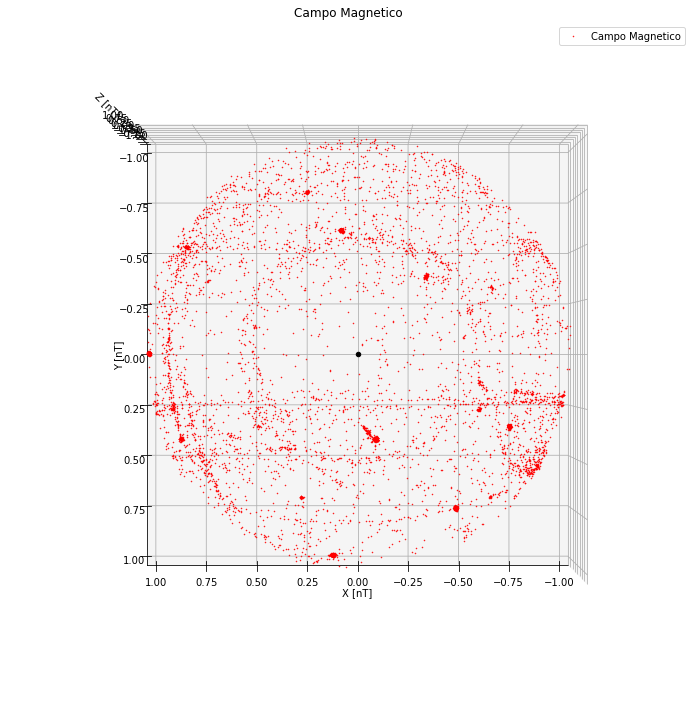

In [15]:
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(10)

ax = plt.axes(projection ='3d')

ax.set_title("Campo Magnetico")

ax.plot3D(xcomp,ycomp,zcomp, 'r.',markersize=1,label='Campo Magnetico')



ax.scatter(0,0,0,color='black')
ax.set_xlabel('X [nT]')
ax.set_ylabel('Y [nT]')
ax.set_zlabel('Z [nT]')
ax.view_init(elev=90., azim=90)
plt.legend(loc='upper right')
plt.grid()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.tight_layout()

plt.show()

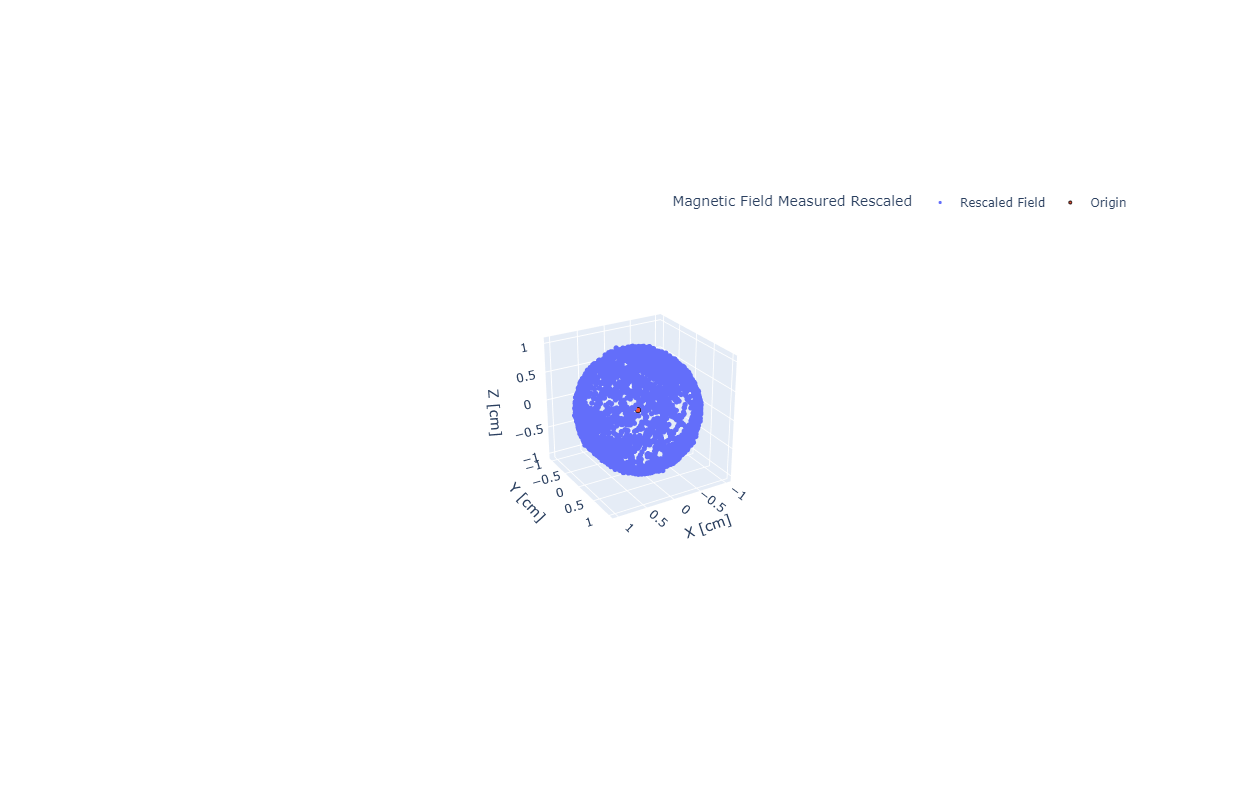

In [19]:
data2=[go.Scatter3d(x=xcomp,y=ycomp,z=zcomp,
                   mode='markers',
                   name="Rescaled Field",
                   opacity=1.0,
                   marker=dict(size=3,line=dict(width=0)), 
                  ),
      go.Scatter3d(x=[0],y=[0],z=[0],mode='markers',name='Origin',
                  marker=dict(size=3,line=dict(color="black",width=1)),)
                  
      ]

layout = go.Layout(
    #title='Posiciones de medida del campo para el Magnetometro 2 representado con PlotLy',
    autosize=True,
    showlegend=True,
    legend_title="Magnetic Field Measured Rescaled",

#    font=dict( family="Courier New, monospace", size=8, color="RebeccaPurple"),
    scene = dict(   xaxis_title='X [cm]',xaxis = dict(nticks=5, range=[-1.1,1.1]),
                    yaxis_title='Y [cm]',yaxis = dict(nticks=5, range=[-1.1,1.1]),
                    zaxis_title='Z [cm]',zaxis = dict(nticks=5, range=[-1.1,1.1])
                ),  
                margin=dict(t=40, r=0, l=20, b=20)
)
#How camera controls work
#The camera position and direction is determined by three vectors: up, center, eye. 
# Their coordinates refer to the 3-d domain, i.e., (0, 0, 0) is always the center of the domain, no matter data values.
# The eye vector determines the position of the camera. The default is $(x=1.25, y=1.25, z=1.25)$.
# The up vector determines the up direction on the page. The default is $(x=0, y=0, z=1)$, that is, the z-axis points up.
# The projection of the center point lies at the center of the view. By default it is $(x=0, y=0, z=0)$.
# 
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=2)
)
#Posición de la Leyenda
legend=dict(
    orientation="h",
    yanchor="top",   y=0.8,
    xanchor="right", x=0.9
)

fig2 = go.Figure(data2,layout)
fig2.update_layout(scene_camera=camera, width=800, height=800,legend=legend)
#Ratio de aspecto para que todos loso ejes se vean con el mismo tamaño
fig2.update_layout(
        scene = dict(
            aspectmode='cube'
        ))
fig2.show()

In [1]:
%run -i CountLines.py Fit_Ellipsoid.ipynb

CODE LINES
421
